In [1]:
import pathlib
import pickle
import numpy as np

# Load data for the experiments
# This are samples from a multi-fidelity experiment with 3 levels of fidelity, 
# where the high-fidelity function is a Gaussian process realization with 
# mean 0 and an exponential kernel.
data_fp = pathlib.Path("../tests/data/data_exp.pkl")
with open(data_fp, "rb") as fh:
    data_pkl: dict[str, np.ndarray] = pickle.load(fh)

locs_lf = data_pkl["locs_lf"]
locs_mf = data_pkl["locs_mf"]
locs_hf = data_pkl["locs_hf"]

obs_lf = data_pkl["obs_lf"]
obs_mf = data_pkl["obs_mf"]
obs_hf = data_pkl["obs_hf"]

In [ ]:
from scipy.spatial.distance import cdist
import torch

# needed to add a small jitter for stability, 
# avoid singularity for locations that are 
# the same in different fidelities
dist_mf = cdist(locs_mf, locs_mf)
epsilon_1 = dist_mf[dist_mf!=0.0].min()/2
epsilon_1_col = torch.zeros(100, 1) + epsilon_1
locs_lf = torch.hstack((locs_lf, epsilon_1_col))

dist_hf = cdist(locs_hf, locs_hf)
epsilon_2 = dist_hf[dist_hf!=0.0].min()/5
epsilon_2_col = torch.zeros(400, 1) + epsilon_2
locs_mf = torch.hstack((locs_mf, epsilon_2_col))

locs_hf = torch.hstack((locs_hf, torch.zeros(3600,1)))

In [23]:

# Some locations have to be left out to avoid singular matrices,
# since Gaussian distribution is completely determined by
# the highest fidelity locations, but we still want to look
# at all the other locations for the variance decay plots 
# and the Kriging weights plots.
left_out_hf = []
for j in range(20):
    for i in range(20):
        left_out_hf.append(int(180*j + 3*i))

locs_hf_np = locs_hf.detach().numpy()
locs_hf_nlo = np.delete(locs_hf_np, left_out_hf, axis=0)

left_out_mf = []
for j in range(10):
    for i in range(10):
        left_out_mf.append(int(40*j + 2*i))

locs_mf_np = locs_mf.detach().numpy()
locs_mf_nlo = np.delete(locs_mf_np, left_out_mf, axis=0)

In [24]:
from gpytorch.kernels import MaternKernel
import torch

exp_cov = MaternKernel(0.5)
cov_hf_orig = exp_cov(locs_hf).evaluate()

list_of_cols = []
list_of_coords = []
for j in range(20):
    for i in range(20):
        col_now = np.zeros(3600)
        # Indices of the 9 high-fidelity points to be averaged
        idx_change = [180*j + 3*i, 180*j + 3*i + 1, 180*j + 3*i + 2, 
                     180*j + 3*i + 60, 180*j + 3*i + 61, 180*j + 3*i + 62,
                     180*j + 3*i + 120, 180*j + 3*i + 121, 180*j + 3*i + 122]
        locs_changed = locs_hf[idx_change]
        x = torch.mean(locs_changed[:,0])
        y = torch.mean(locs_changed[:,1])
        locs_now = [x.item(), y.item()]
        col_now[idx_change] = 1/9
        list_of_cols.append(col_now)
        list_of_coords.append(locs_now)

A = np.stack(list_of_cols, axis=0)
A = torch.from_numpy(A)
A = A.type(torch.float64)

cov_mf_orig = A @ cov_hf_orig @ A.mT

list_of_cols = []
list_of_coords = []
for j in range(10):
    for i in range(10):
        col_now = np.zeros(400)
        # Indices of the 4 middle-fidelity points to be averaged
        idx_change = [40*j + 2*i, 40*j + 2*i + 1, 40*j + 2*i + 20, 
                      40*j + 2*i + 21]
        locs_changed = locs_mf[idx_change]
        x = torch.mean(locs_changed[:,0])
        y = torch.mean(locs_changed[:,1])
        locs_now = [x.item(), y.item()]
        col_now[idx_change] = 1/4
        list_of_cols.append(col_now)
        list_of_coords.append(locs_now)

A2 = np.stack(list_of_cols, axis=0)
A2 = torch.from_numpy(A2)
A2 = A2.type(torch.float64)

cov_lf_orig = A2 @ cov_mf_orig @ A2.mT

In [6]:
def revMat(mat):
    # Reverse rows and columns using numpy slicing
    return np.flip(mat, axis=0)[:, ::-1]

def cond_sd(cov):
    # Compute the conditional standard deviations from a covariance matrix
    aux = revMat(cov.detach().numpy())
    aux2 = np.linalg.inv(aux)
    aux3 = np.linalg.cholesky(aux2)
    aux4 = np.transpose(aux3)
    U_unnormed = revMat(aux4)
    return 1/np.diag(U_unnormed)

# Empirical illustration

Here we plot a sample from the exponential covariance model for illustration. Theory [Schafer, F., Katzfuss, M., and Owhadi, H. (2021)] tells us that this process has a particular variance decay structure (polynomial decay) and a particular approximate screening effect (i.e., Kriging weights decay exponentially with neighbor number) under the conditional maximin ordering, but let's observe that in practice for this multi-fidelity sample. 

<Figure size 640x480 with 0 Axes>

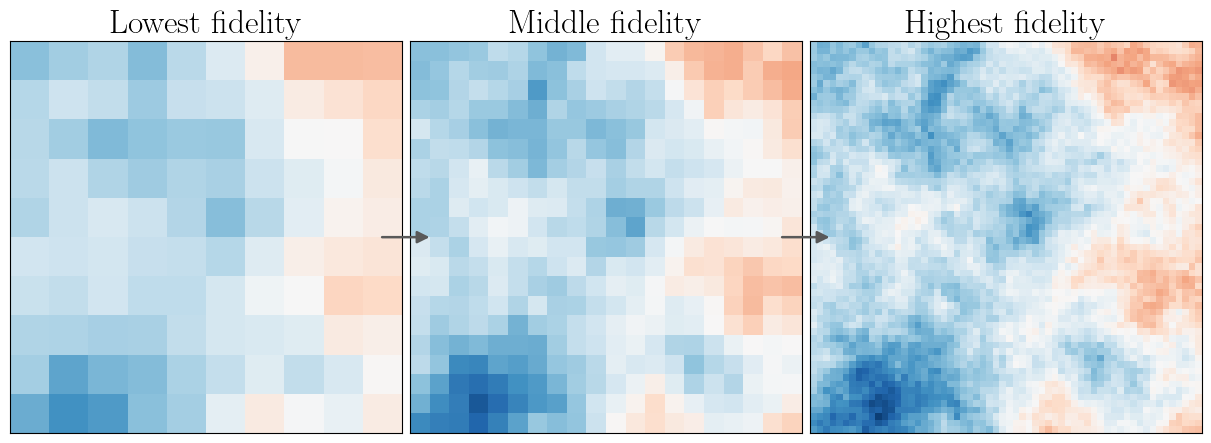

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

def connect_arrow(ax_from, ax_to, y=0.50, color='0.70', lw=1.8, ms=18, rad=0.0):
    """
    Arrow from the right edge of ax_from to the left edge of ax_to,
    at normalized vertical position y (0..1).
    """
    con = ConnectionPatch(
        (0.95, y), (0.05, y),
        coordsA=ax_from.transAxes, coordsB=ax_to.transAxes,
        arrowstyle="-|>", mutation_scale=ms,
        lw=lw, color=color,
        connectionstyle=f"arc3,rad={rad}",
        shrinkA=0, shrinkB=0, clip_on=False,
    )
    ax_from.figure.add_artist(con)

plt.rc('font', size=12*2)
plt.rc('axes', titlesize=12*2)
plt.rc('axes', labelsize=12*2)
plt.rc('xtick', labelsize=8*2)
plt.rc('ytick', labelsize=8*2)
plt.rc('legend', fontsize=9*2)
plt.rc('figure', titlesize=12*2)
plt.rc('font', family='serif')  # e.g., Times

plt.set_cmap('RdBu_r')

fig, axs = plt.subplots(1,3, figsize=(12,6), constrained_layout = True)
y_hf = obs_hf[33]
y_mf = obs_mf[33]
y_lf = obs_lf[33]

vmin = -3.0
vmax = 3.0

im = axs[0].imshow(y_lf.reshape(10,10), vmin=vmin, vmax=vmax)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Lowest fidelity")

im = axs[1].imshow(y_mf.reshape(20,20), vmin=vmin, vmax=vmax)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Middle fidelity")

im = axs[2].imshow(y_hf.reshape(60,60), vmin=vmin, vmax=vmax)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Highest fidelity")

# Draw the two arrows
connect_arrow(axs[0], axs[1], y=0.50, color = '0.35')     # panel 1 -> panel 2
connect_arrow(axs[1], axs[2], y=0.50, color = '0.35')     # panel 2 -> panel 3

# uncomment to save on file
#plt.savefig('./sample_exponential.pdf', dpi=300)

In [ ]:
from batram.base_functions import compute_scale
from veccs.orderings import maxmin_pred_cpp, find_nns_l2_mf

# conditional maxmin ordering
ord_lfmf = maxmin_pred_cpp(locs_lf.detach().numpy(), locs_mf_nlo)

locs_lfmf = np.vstack((locs_lf, locs_mf_nlo))
ord_hf = maxmin_pred_cpp(locs_lfmf, locs_hf_nlo)

ord = np.concatenate((ord_lfmf, ord_hf[400:]))
locs_nlo = torch.vstack((locs_lf, torch.Tensor(locs_mf_nlo), torch.Tensor(locs_hf_nlo)))
locs_ord = locs_nlo[ord, ...]

locs_all = [locs_ord[:100], locs_ord[100:400], locs_ord[400:]]
largest_conditioning_set = 2
NN = find_nns_l2_mf(locs_all, largest_conditioning_set)

ord_lf = ord[:100]
ord_mf = ord[100:400] - 100
ord_hf = ord[400:] - 400

In [ ]:
from batram.base_functions import scaling_mf

# get covariance, scaling for plots
cov = exp_cov(locs_ord).evaluate()
cond_sds = cond_sd(cov)
scales = scaling_mf(locs_ord, NN, np.array([100, 300, 3200]))

In [ ]:
from sklearn.linear_model import LinearRegression
from matplotlib import rc
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
import matplotlib.pyplot as plt
import numpy as np

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{xcolor}')

# latex preamble for pgf plots
pgf_with_latex = {
    "text.usetex": True,            # Use LaTeX to write all text
    "pgf.rcfonts": False,           # Ignore Matplotlibrc
    "pgf.preamble": r'\usepackage{xcolor}'  # Use xcolor for better color support
}

matplotlib.rcParams.update(pgf_with_latex)
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

import matplotlib.pyplot as plt

# Set global font sizes
plt.rc('font', size=1.75*12)  
plt.rc('axes', titlesize=1.75*12)  
plt.rc('axes', labelsize=1.75*12) 
plt.rc('xtick', labelsize=1.75*8)  
plt.rc('ytick', labelsize=1.75*8)  
plt.rc('legend', fontsize=1.75*9)  
plt.rc('figure', titlesize=1.75*12)  

plt.rc('font', family='serif')  

# Conditional variance decay

Check that the actual conditional variance decay in this Gaussian example decay polynomially in the conditional maximin order index. 

Text(-0.2, 0.5, 'Conditional SDs')

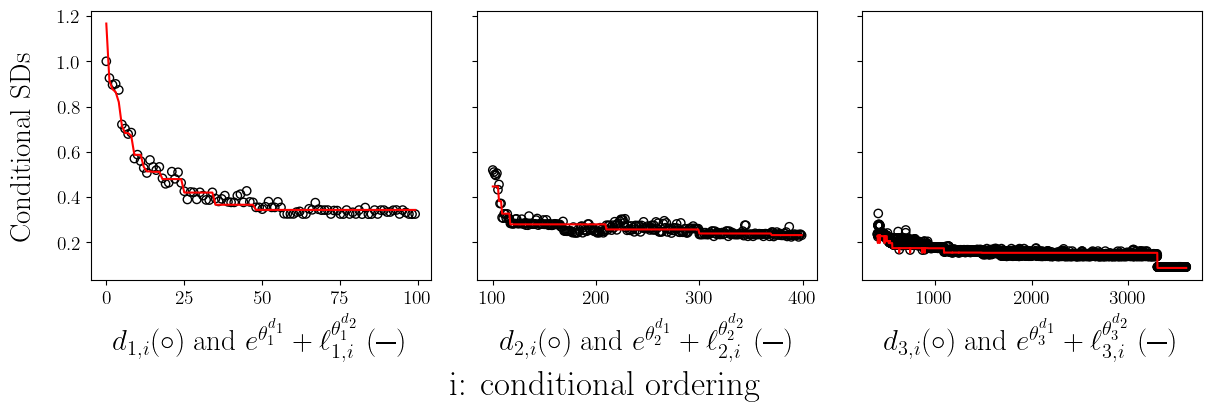

In [ ]:
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf

gspec = {"wspace": 0.1, "hspace": 0.1}

fig, ax = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw=gspec, sharey=True, constrained_layout = True)#, squeeze=True)

cond_sd_lf = cond_sds[:100]
lm = LinearRegression()
scales_lf = scales[:100].detach().numpy()
lm.fit(np.log(scales_lf).reshape(-1, 1), np.log(cond_sd_lf))
x = range(0,100)
y = np.exp(lm.intercept_ + lm.coef_ * np.log(scales_lf))
ax[0].scatter(x, cond_sd_lf, facecolors='none', edgecolors='black')
ax[0].plot(x, y, color='red')
ax[0].set_xlabel(r'$d_{1,i} (\circ)$ and  $e^{\theta_1^{d_1}} + \ell_{1,i}^{\theta_1^{d_2}}$' + r'  ({\textcolor{red}{\rule[0.5ex]{0.5cm}{1pt}}})')

cond_sd_mf = cond_sds[100:400]
lm = LinearRegression()
scales_mf = scales[100:400].detach().numpy()
lm.fit(np.log(scales_mf).reshape(-1, 1), np.log(cond_sd_mf))
x = range(100,400)
y = np.exp(lm.intercept_ + lm.coef_ * np.log(scales_mf))
ax[1].scatter(x, cond_sd_mf, facecolors='none', edgecolors='black')
ax[1].plot(x, y, color='red')
ax[1].set_xlabel(r'$d_{2,i} (\circ)$ and  $e^{\theta_2^{d_1}} + \ell_{2,i}^{\theta_2^{d_2}}$' + r'  ({\textcolor{red}{\rule[0.5ex]{0.5cm}{1pt}}})')

cond_sd_hf = cond_sds[400:3600]
lm = LinearRegression()
scales_hf = scales[400:].detach().numpy()
lm.fit(np.log(scales_hf).reshape(-1, 1), np.log(cond_sd_hf))
x = range(400,3600)
y = np.exp(lm.intercept_ + lm.coef_ * np.log(scales_hf))
ax[2].scatter(x, cond_sd_hf, facecolors='none', edgecolors='black')
ax[2].plot(x, y, color='red')
ax[2].set_xlabel(r'$d_{3,i} (\circ)$ and  $e^{\theta_3^{d_1}} + \ell_{3,i}^{\theta_3^{d_2}}$' + r'  ({\textcolor{red}{\rule[0.5ex]{0.5cm}{1pt}}})')

fig.supxlabel('i: conditional ordering')
fig.canvas.draw()  # ensure positions are up-to-date (needed with constrained_layout)

# left edge of the left subplot, in figure coords
left_edge = ax[0].get_position().x0

# vertical center of all subplots (since sharey=True, this is fine)
bottom = min(a.get_position().y0 for a in ax)
top    = max(a.get_position().y1 for a in ax)
y_c    = 0.5*(bottom + top)

# Put the y label relative to the left axis, not the figure
ax[0].text(
    -0.2, 0.5, 'Conditional SDs',
    rotation=90, va='center', ha='center',
    transform=ax[0].transAxes, clip_on=False
)
# uncomment to save
#plt.savefig('./conditional_ordering.pdf', dpi=300)

In [20]:
# get cholesky for kriging weights
def get_U(cov):
    aux = revMat(cov.detach().numpy())
    aux2 = np.linalg.inv(aux)
    aux3 = np.linalg.cholesky(aux2)
    aux4 = np.transpose(aux3)
    U_unnormed = revMat(aux4)
    cond_sds = 1/np.diag(U_unnormed)
    U = U_unnormed.T * cond_sds

    return U

U = get_U(cov)

C:\Users\Aleja\AppData\Local\Temp\ipykernel_12856\3834305691.py:84: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.5)


Text(-0.2, 0.5, 'mean squared weights')

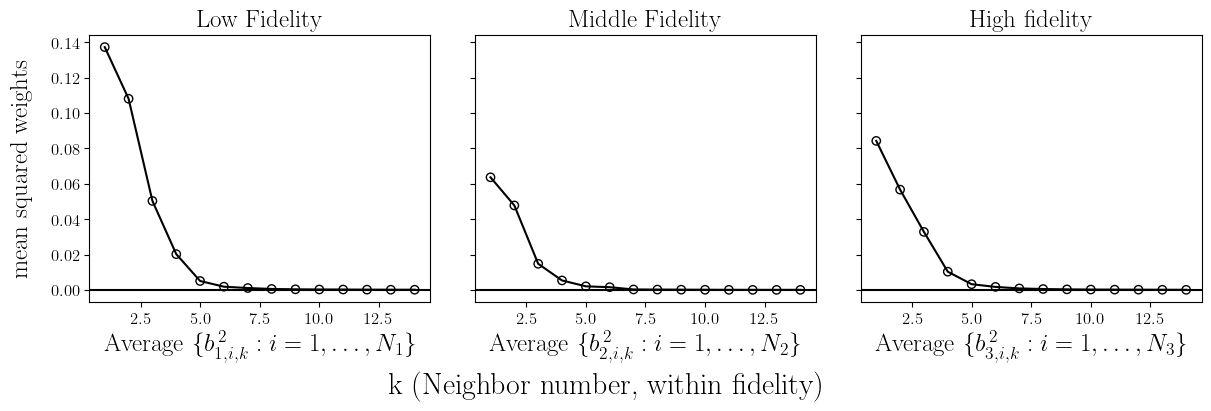

In [21]:
# smaller font sizes look better in the overall plot
plt.rc('font', size=1.5*12)  # Default font size for text
plt.rc('axes', titlesize=1.5*12)  # Font size for axes titles
plt.rc('axes', labelsize=1.5*12)  # Font size for x and y labels
plt.rc('xtick', labelsize=1.5*8)  # Font size for x-tick labels
plt.rc('ytick', labelsize=1.5*8)  # Font size for y-tick labels
plt.rc('legend', fontsize=1.5*9)  # Font size for legend
plt.rc('figure', titlesize=1.5*12)  # Font size for figure titles

gspec = {"wspace": 0.1, "hspace": 0.1}
fig, ax = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw=gspec, sharey=True, constrained_layout = True)#, squeeze=True)

# 30 neighbors max for weights
nn = find_nns_l2_mf(locs_all, 30)
weights = np.empty((100, 30))
weights[:] = np.nan
for i in range(100):
    nn_now = nn[i,0:30]
    mask = nn_now != -1.0
    nn_now = nn_now[mask]
    for j in range(len(nn_now)):
        weights[i,j] = -U[nn_now[j], i]

weights_sq = weights**2
# nanmean because some points have less than 30 neighbors
squared_dev = np.nanmean(weights_sq, axis=0)
# 15 was enough to see the pattern
k = range(1, 15)
ax[0].scatter(k, squared_dev[0:14], facecolors='none', edgecolors='black')
ax[0].plot(k, squared_dev[0:14], color='black')
ax[0].title.set_text('Low Fidelity')
ax[0].axhline(y=0.0, color='black', linestyle='-')
ax[0].set_xlabel(r'Average $\{ b_{1,i,k}^{\,2}: i = 1, \dots, N_1 \}$')

weights = np.empty((300, 30))
weights[:] = np.nan
for i in range(300):
    nn_now = nn[i+100,0:30]
    mask = nn_now != -1.0
    nn_now = nn_now[mask]
    for j in range(len(nn_now)):
        # be careful with the indexing here
        weights[i,j] = -U[nn_now[j], i+100]

weights_sq = weights**2
squared_dev = np.nanmean(weights_sq, axis=0)
k = range(1, 15)
ax[1].scatter(k, squared_dev[0:14], facecolors='none', edgecolors='black')
ax[1].plot(k, squared_dev[0:14], color='black')
ax[1].title.set_text('Middle Fidelity')
ax[1].axhline(y=0.0, color='black', linestyle='-')
ax[1].set_xlabel(r'Average $\{ b_{2,i,k}^{\,2}: i = 1, \dots, N_2 \}$')

weights = np.empty((3200, 30))
weights[:] = np.nan
for i in range(3200):
    nn_now = nn[i+400,0:30]
    mask = nn_now != -1.0
    nn_now = nn_now[mask]
    for j in range(len(nn_now)):
        # be careful with the indexing here
        weights[i,j] = -U[nn_now[j], i+400]

weights_sq = weights**2
squared_dev = np.nanmean(weights_sq, axis=0)
k = range(1, 15)
ax[2].scatter(k, squared_dev[0:14], facecolors='none', edgecolors='black')
ax[2].plot(k, squared_dev[0:14], color='black')
ax[2].title.set_text('High fidelity')
ax[2].axhline(y=0.0, color='black', linestyle='-')
ax[2].set_xlabel(r'Average $\{ b_{3,i,k}^{\,2}: i = 1, \dots, N_3 \}$')

fig.supxlabel('k (Neighbor number, within fidelity)')
fig.canvas.draw()  # ensure positions are up-to-date (needed with constrained_layout)

# left edge of the left subplot, in figure coords
left_edge = ax[0].get_position().x0

# vertical center of all subplots (since sharey=True, this is fine)
bottom = min(a.get_position().y0 for a in ax)
top    = max(a.get_position().y1 for a in ax)
y_c    = 0.5*(bottom + top)

fig.subplots_adjust(left=0.5)

# Put the y label relative to the left axis, not the figure
ax[0].text(
    -0.2, 0.5, 'mean squared weights',
    rotation=90, va='center', ha='center',
    transform=ax[0].transAxes, clip_on=False
)

#plt.savefig('./kriging_within.pdf', dpi=300)

C:\Users\Aleja\AppData\Local\Temp\ipykernel_12856\1160898483.py:63: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.5)


Text(-0.2, 0.5, 'mean squared weights')

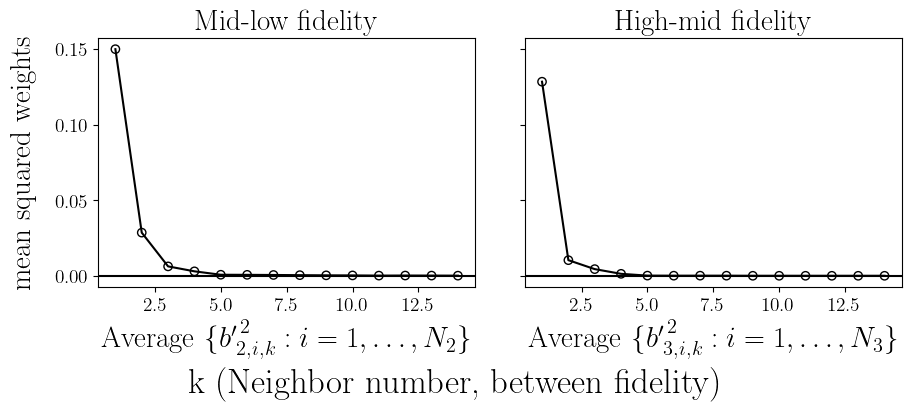

In [22]:
# increase font size again
plt.rc('font', size=1.75*12)  # Default font size for text
plt.rc('axes', titlesize=1.75*12)  # Font size for axes titles
plt.rc('axes', labelsize=1.75*12)  # Font size for x and y labels
plt.rc('xtick', labelsize=1.75*8)  # Font size for x-tick labels
plt.rc('ytick', labelsize=1.75*8)  # Font size for y-tick labels
plt.rc('legend', fontsize=1.75*9)  # Font size for legend
plt.rc('figure', titlesize=1.75*12)  # Font size for figure titles

gspec = {"wspace": 0.1, "hspace": 0.1}
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw=gspec, sharey=True, constrained_layout = True)#, squeeze=True)

weights = np.empty((300, 30))
weights[:] = np.nan
for i in range(300):
    # nn 30-60 are the neighbors from other fidelity
    nn_now = nn[100+i,30:60]
    mask = nn_now != -1.0
    nn_now = nn_now[mask]
    for j in range(len(nn_now)):
        weights[i,j] = -U[nn_now[j], i+100]

weights_sq = weights**2
squared_dev = np.nanmean(weights_sq, axis=0)
k = range(1, 15)
ax[0].scatter(k, squared_dev[0:14], facecolors='none', edgecolors='black')
ax[0].plot(k, squared_dev[0:14], color='black')
ax[0].title.set_text('Mid-low fidelity')
ax[0].axhline(y=0.0, color='black', linestyle='-')
ax[0].set_xlabel(r"Average $\{ {b'}_{2,i,k}^{\,2} : i = 1, \dots, N_2 \}$")

weights = np.empty((3200, 30))
weights[:] = np.nan
for i in range(3200):
    nn_now = nn[400+i,30:60]
    mask = nn_now != -1.0
    nn_now = nn_now[mask]
    for j in range(len(nn_now)):
        weights[i,j] = -U[nn_now[j], i+400]

weights_sq = weights**2
squared_dev = np.nanmean(weights_sq, axis=0)
k = range(1, 15)
ax[1].scatter(k, squared_dev[0:14], facecolors='none', edgecolors='black')
ax[1].plot(k, squared_dev[0:14], color='black')
ax[1].title.set_text('High-mid fidelity')
ax[1].axhline(y=0.0, color='black', linestyle='-')
ax[1].set_xlabel(r"Average $\{ {b'}_{3,i,k}^{\,2} : i = 1, \dots, N_3 \}$")

fig.supxlabel('k (Neighbor number, between fidelity)')
fig.canvas.draw()  # ensure positions are up-to-date (needed with constrained_layout)

# left edge of the left subplot, in figure coords
left_edge = ax[0].get_position().x0

# vertical center of all subplots (since sharey=True, this is fine)
bottom = min(a.get_position().y0 for a in ax)
top    = max(a.get_position().y1 for a in ax)
y_c    = 0.5*(bottom + top)

# small left padding in figure coords; tweak if needed (0.02–0.05)
pad = 0.06
fig.subplots_adjust(left=0.5)

# Put the y label relative to the left axis, not the figure
ax[0].text(
    -0.2, 0.5, 'mean squared weights',
    rotation=90, va='center', ha='center',
    transform=ax[0].transAxes, clip_on=False
)
#plt.savefig('./kriging_between.pdf', dpi=300)